In [1]:
import csv
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import jieba
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE

In [2]:
DATA_PATH = "./data/SexComment.csv"

def load_data(path):
    with open(path, "r", encoding="utf8") as f:
        reader = csv.reader(f, delimiter=',',)
        headers = next(reader)
        raw = [_ for _ in reader]
        return pd.DataFrame(raw, columns=headers)

df = load_data(path=DATA_PATH)
print(df[:3])
print(f"\ndataset summary:\n{df.groupby('label').size()}")

  ﻿index   weibo_id                                    comment_text gender  \
0      0  J1zF7smOR                      她们不结婚不要孩子，却觉得我们这种结婚有孩子的是婚驴      女   
1      1  GvXf0ymdJ                       妈的什么时候有人来性侵我一下啊  不要封口费的那种      男   
2      2  J2XeR8rPn  我觉得这就是对一类人所有的特点进行形容吧，“爹味”也是贬义词，为什么不觉得有性别歧视意味呢？      女   

  location like              date label category target  
0       广东   14  12/05/2020 15:04     1      SCB      G  
1       其他   36  23/08/2018 13:10     1       SO      I  
2       浙江    0  21/05/2020 16:12     1       MA      G  

dataset summary:
label
0    5876
1    3093
dtype: int64


In [3]:
# Generate WordBag 
# TODO: 中文停用词 ？ 标点符号？
def tokenize(raw_str, mode="default"):  
    if mode == "full":
        tokens = jieba.cut(raw_str, cut_all=True)
    if mode == "search":
        tokens = jieba.cut_for_search(raw_str)
    else:
        tokens = jieba.cut(raw_str)  
    return " ".join(list(tokens))

raw_tokens = [tokenize(row) for row in df["comment_text"]]
raw_set = set()
for row in raw_tokens:
    for token in row.split(" "):
        raw_set.add(token)
print(f"Full Bag of Words: total {len(raw_set)} words")

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/hs/2j2gy9854xg9z8wh5l0cnxn40000gn/T/jieba.cache
Loading model cost 0.292 seconds.
Prefix dict has been built successfully.


Full Bag of Words: total 28000 words


In [4]:
# BagofWords

vectorizer = CountVectorizer(tokenizer=jieba.lcut)
vectorizer.fit(df["comment_text"])
vocab = pd.DataFrame.from_dict(vectorizer.vocabulary_, orient="index", columns=["index"])
vocab = vocab.sort_values("index")

X = vectorizer.transform(df["comment_text"]).toarray()
counts = np.sum(X, axis=0)

vocab.insert(1, "count", counts, allow_duplicates=True)
vocab = vocab.sort_values("count", ascending=False)

print(f"Bag of words: total {vocab.shape[0]} words")
print(vocab[50:60])

Bag of words: total 27874 words
    index  count
好   10126    950
可以   7594    930
男   19763    921
给   21838    915
去    7053    902
多    9223    888
能   22564    886
呢    8118    883
这种  25500    879
真的  20485    872


In [5]:
# TF-IDF

vectorizer_tfidf = TfidfVectorizer(tokenizer=jieba.lcut)
vectorizer_tfidf.fit(df["comment_text"])
vocab_tfidf = pd.DataFrame.from_dict(vectorizer_tfidf.vocabulary_, orient="index", columns=["index"])
vocab_tfidf = vocab_tfidf.sort_values("index")

X = vectorizer_tfidf.transform(df["comment_text"]).toarray()
weights = np.sum(X, axis=0)

vocab_tfidf.insert(1, "tf_idf", weights, allow_duplicates=True)
vocab_tfidf = vocab_tfidf.sort_values("tf_idf", ascending=False)

print(f"Bag of Words + TF-IDF: total {vocab_tfidf.shape[0]} words")
print(vocab_tfidf[50:60])

Bag of Words + TF-IDF: total 27874 words
    index     tf_idf
男   19763  83.122495
那   25994  78.964058
男性  19833  77.391023
能   22564  76.144945
多    9223  75.947942
他们   3895  75.732084
呢    8118  75.624548
去    7053  74.901450
女    9918  74.619983
这种  25500  74.551177


In [6]:
# Trim First-N words
TOP_N = 10000

vocab_trim = vocab[:TOP_N].index.tolist()
vocab_tfidf_trim = vocab_tfidf[:TOP_N].index.tolist()

print(vocab_trim[:50])
print(vocab_tfidf_trim[:50])

def filter_by_vocab(rows, vocab):
    return [[t for t in row.split(" ") if t in vocab] for row in rows]

filterd_tokens = filter_by_vocab(raw_tokens, vocab_trim)

['，', '的', '。', '是', '了', '我', ' ', '你', '？', '不', '就', '都', '也', '说', '有', '女权', '在', ',', '人', '女性', '自己', '和', '就是', '被', '她', '不是', '他', '没有', '还', '这', '吗', '”', '“', '对', '什么', '！', '啊', '一个', '觉得', '吧', '要', '这个', '没', '…', '男人', '很', '会', '女人', '那', '男性']
['，', '的', '。', ' ', '是', '我', '了', '你', '？', '不', '都', '女权', '就', '也', '说', '有', '人', '在', '女性', '自己', '她', '和', '就是', '被', '他', '！', '不是', '…', '还', '啊', '什么', '吗', '“', '”', '对', '没有', ',', '吧', '这', '觉得', '一个', '男人', '这个', '要', '女人', '没', '很', '会', '好', '真的']


In [7]:
# Embedding: word2vec
EMBEDDING_LENGTH = 100
EMBEDDING_EPOCH = 50
WINDOW_SIZE = 5

model = Word2Vec(
    vector_size=EMBEDDING_LENGTH, 
    window=WINDOW_SIZE, 
    min_count=1, 
    workers=4,
    epochs=EMBEDDING_EPOCH
)
model.build_vocab(filterd_tokens)
model.train(filterd_tokens, total_examples=model.corpus_count, epochs=model.epochs)  # train word vectors
model.save("vanilla_w2v.model")

# get node name and embedding vector index.
name_index = np.array([(k, v) for k, v in model.wv.key_to_index.items()])
# init dataframe using embedding vectors and set index as node name
model_df = pd.DataFrame(model.wv.vectors[name_index[:,1].astype(int)])
model_df.index = name_index[:,0]
model_df.to_csv("vanilla_w2v.csv")
print(model_df.shape)

(9991, 100)


In [9]:
# Add every font at the specified location
font_dir = ["."]
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)

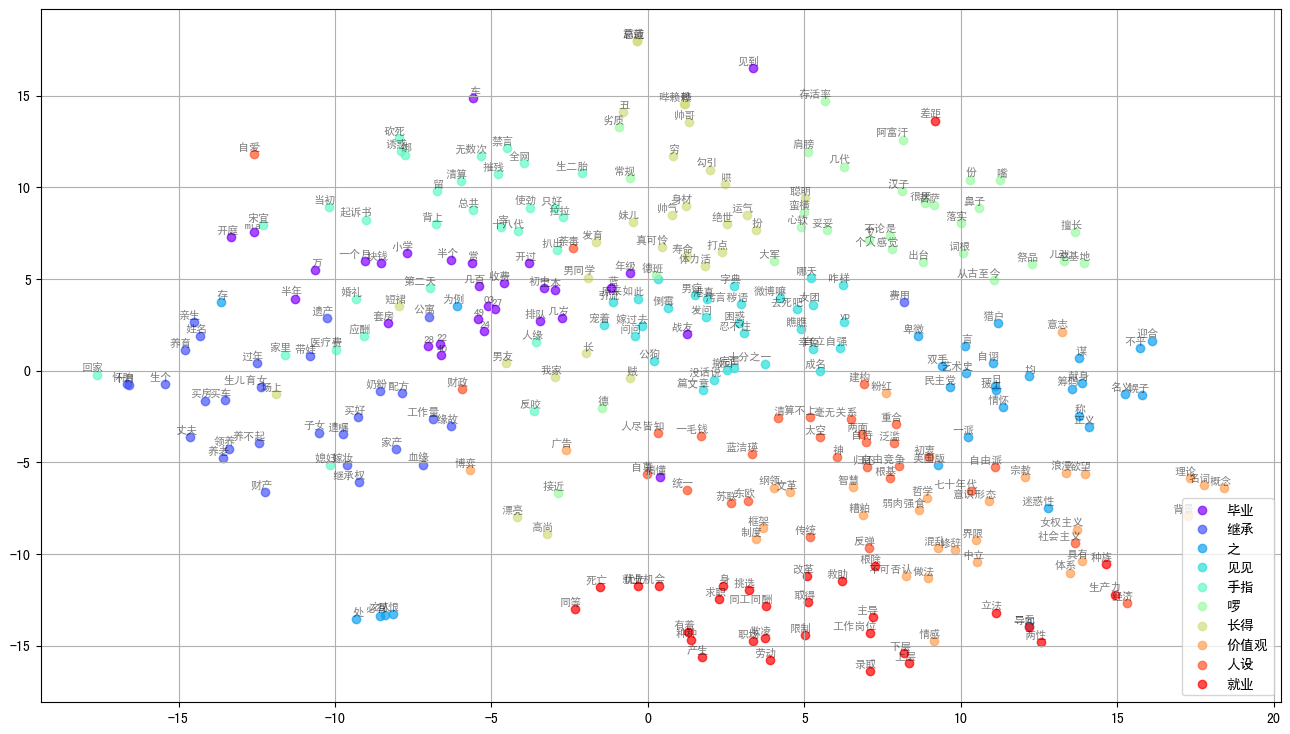

In [10]:
# Visualization: N-closed vectors
presented = random.choices(vocab_trim, k=10)

embedding_clusters = []
word_clusters = []
for word in presented:
    if word == " ":
        continue # SKIP "\s"
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init="pca", n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()


tsne_plot_similar_words(presented, embeddings_en_2d, word_clusters)

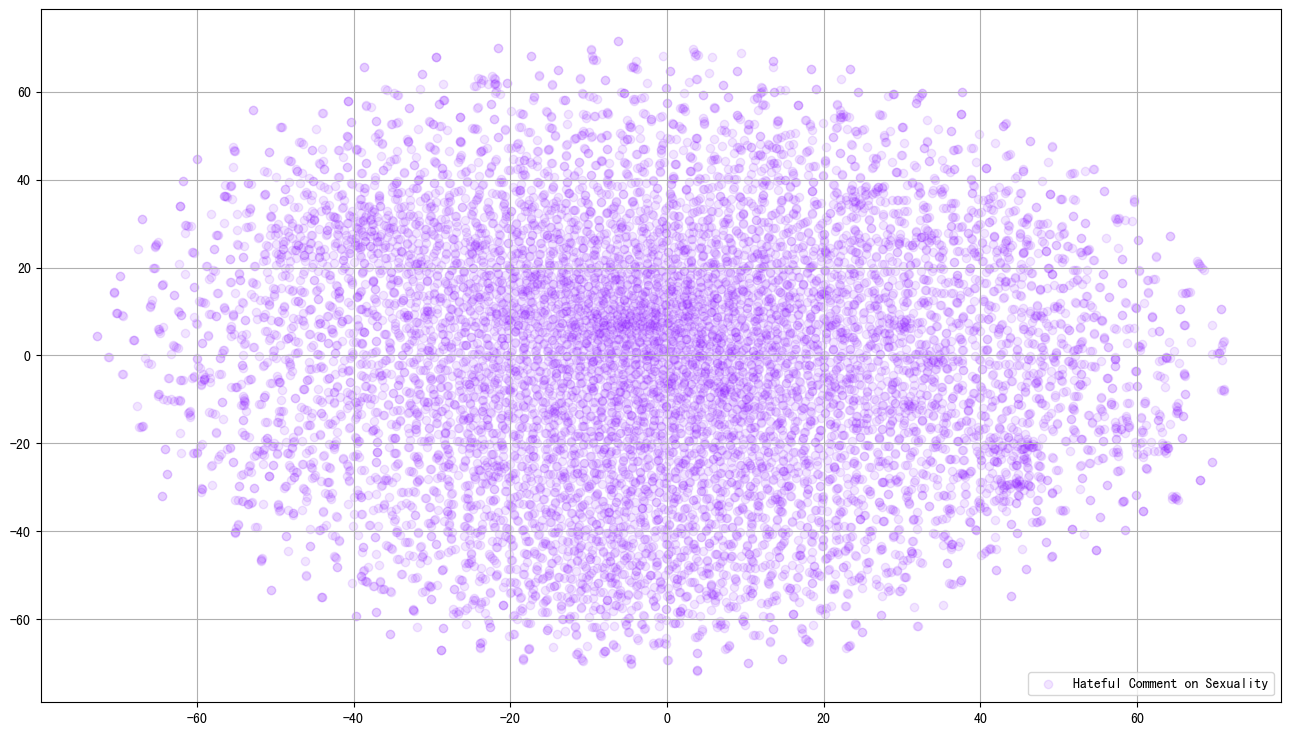

In [11]:
# Visualization: Global
words = []
embeddings = []
for word in list(model.wv.key_to_index.keys()):
    embeddings.append(model.wv[word])
    words.append(word)
    
tsne_ak_2d = TSNE(n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings)

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords="offset points", ha="right", va="bottom", size=10)
    plt.legend(loc=4)
    plt.grid(True)
#     plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d("Hateful Comment on Sexuality", embeddings_ak_2d, a=0.1)

## Naive SVM + word2vec

In [137]:
# prepare dataset
import os
from sklearn import model_selection, svm

random.seed(7101)

labels, comments = df["label"].to_numpy(), df["comment_text"].to_numpy()
assert len(labels) == len(comments)

# Define Dataset
TRAIN_TEST_RATIO = 0.2
TRAIN_VALID_RATIO = 0.1
data_X, test_X, data_y, test_y = model_selection.train_test_split(comments, labels, test_size=TRAIN_TEST_RATIO)
train_X, valid_X, train_y, valid_y = model_selection.train_test_split(data_X, data_y, test_size=TRAIN_VALID_RATIO)
assert train_X.shape == train_y.shape and test_X.shape == test_y.shape and valid_X.shape == valid_y.shape

def dump_dataset(X, y, filename):
    with open(filename, "w", encoding="utf8") as f:
        for comment, label in zip(X, y):
            f.write(f"{label},{comment}\n")

dump_dataset(train_X, train_y, "./data/trainset1103.txt")
dump_dataset(valid_X, valid_y, "./data/validset1103.txt")
dump_dataset(test_X, test_y, "./data/testset1103.txt")

print(f"train dataset: {train_X.shape}, test dataset: {test_X.shape}, validation dataset: {valid_X.shape}")

train dataset: (6457,), test dataset: (1794,), validation dataset: (718,)


In [200]:
import gensim
SEQUENCE_LEN = 30

# word2vec
pretrained_model = Word2Vec.load('./model/word2vec.model')
# pretrained_model = gensim.models.KeyedVectors.load_word2vec_format('./model/word2vec.txt', binary=False)

# fine-tune model
train_vocab = [list(jieba.cut(line)) for line in data_X]
print(train_vocab[0])

pretrained_model.build_vocab(train_vocab, update=True)
pretrained_model.train(train_vocab, total_examples=pretrained_model.corpus_count, epochs=pretrained_model.epochs)

# print(pretrained_model.wv["酱缸"])

abnormal_words = set()
sequence_len = []

def prepare_dataset(data, seq_len=SEQUENCE_LEN, is_train=True):
    for line in data:
        vectors = []
        for token in jieba.cut(line):
            token = token.strip()
            if token:
#                 vectors.append(pretrained_model.wv[token])
                try: 
                    vectors.append(pretrained_model.wv[token])
                except Exception as err:
                    abnormal_words.add(token)
        if is_train:
            sequence_len.append(len(vectors))
        yield np.sum(vectors[:seq_len], axis=0)
# sum / avg, norm => normalization

train_sum_X = np.array(list(prepare_dataset(train_X, is_train=True)))
valid_sum_X = np.array(list(prepare_dataset(valid_X, is_train=True)))
test_sum_X = np.array(list(prepare_dataset(test_X)))
print(train_sum_X.shape, valid_sum_X.shape, test_sum_X.shape)

with open("./data/abnormal_words.txt", "w", encoding="utf8") as f:
    for word in list(abnormal_words):
        f.write(f"{word}\n")
        
print(f"words not found: {len(abnormal_words)}")

['当年', '法官', '认为', '证据', '无法', '证明', '性侵', '发生', '结的案', '，', '有火', '去', '找', '法院', '撒', '或者', '重新', '提起', '诉讼', '告伍', '迪', '艾伦', '都行', '啊', '，', '年', '年', '道德', '绑架', '女演员', '逼人', '站队', '，', '简直', '有', '毛病', '，', '怎么', '不去', '真正', '掌控', '资本', '的', '制片', '公司', '门口', '贴', '大字报', '？', '\xa0', '举报', '\xa0', '赞', '[', '24', ']', '\xa0', '回复', '\xa0', '2018', '-', '01', '-', '18', ' ', '00', ':', '51', ':', '02', '\xa0', '来自', '网页']
(6457, 100) (718, 100) (1794, 100)
words not found: 1052


seq_len min: 6, max: 1512, medium: 29.0


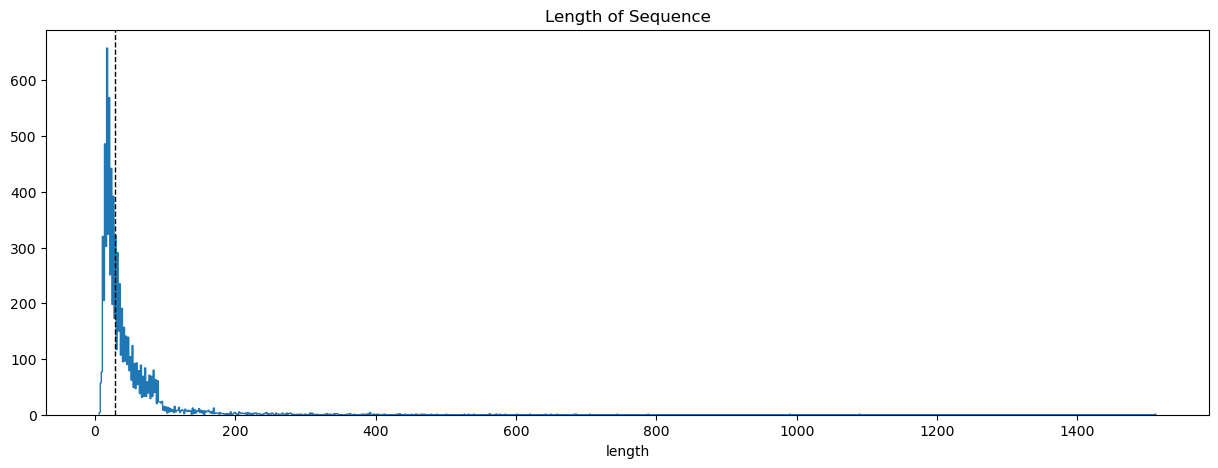

In [158]:
from scipy import stats

# visualization: best components size
fig, axe = plt.subplots(1, 1, figsize = (15, 5))
axe.set_xlabel(r"length")
axe.set_title(r"Length of Sequence")
counts, bins = np.histogram(sequence_len, bins=1000)
plt.stairs(counts, bins)

plt.axvline(np.median(sequence_len), color='k', linestyle='dashed', linewidth=1)
# seq_len_mode = stats.mode(sequence_len)
print(f"seq_len min: {np.min(sequence_len)}, max: {np.max(sequence_len)}, medium: {np.median(sequence_len)}")

In [219]:
import pickle
from sklearn.metrics import *

seq_lens = [30, 50, 100, 300, 500, 100000]

normal_train_pr, normal_train_rc = [], []
hate_train_pr, hate_train_rc = [], []

normal_valid_pr, normal_valid_rc = [], []
hate_valid_pr, hate_valid_rc = [], []

train_accus, valid_accus = [], []

for seq_len in seq_lens:
    train_sum_X = np.array(list(prepare_dataset(train_X, seq_len=seq_len)))
    valid_sum_X = np.array(list(prepare_dataset(valid_X, seq_len=seq_len)))
    test_sum_X = np.array(list(prepare_dataset(test_X, seq_len=seq_len)))
    print(train_sum_X.shape, valid_sum_X.shape, test_sum_X.shape)

    # SVM
    # fit the training dataset on the classifier
    sum_SVM = svm.SVC(kernel='rbf', class_weight="balanced")
    # SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    sum_SVM.fit(train_sum_X, train_y)

    pickle.dump(SVM, open("./model/naive_sum_svm.pkl", 'wb'))

    # predict the labels on validation dataset
    pred_train_sum = sum_SVM.predict(train_sum_X)
    pred_valid_sum = sum_SVM.predict(valid_sum_X)

    # Use accuracy_score function to get the accuracy
    target_names = ["normal", "hate"]
    train_accu = accuracy_score(pred_train_sum, train_y)
    print("SVM Accuracy Train -> ", train_accu)
    print(confusion_matrix(train_y, pred_train_sum))
    report = classification_report(train_y, pred_train_sum, target_names=target_names, output_dict=True)
    normal_train_pr.append(report["normal"]["precision"])
    normal_train_rc.append(report["normal"]["recall"])
    hate_train_pr.append(report["hate"]["precision"])
    hate_train_rc.append(report["hate"]["recall"])
    print(report)
    train_accus.append(train_accu)
    

    valid_accu = accuracy_score(pred_valid_sum, valid_y)
    print("SVM Accuracy Validation -> ", valid_accu)
    print(confusion_matrix(valid_y, pred_valid_sum))
    report = classification_report(valid_y, pred_valid_sum, target_names=target_names, output_dict=True)
    normal_valid_pr.append(report["normal"]["precision"])
    normal_valid_rc.append(report["normal"]["recall"])
    hate_valid_pr.append(report["hate"]["precision"])
    hate_valid_rc.append(report["hate"]["recall"])
    print(report)
    valid_accus.append(valid_accu)

(6457, 100) (718, 100) (1794, 100)
SVM Accuracy Train ->  0.7647514325538176
[[3295  917]
 [ 602 1643]]
{'normal': {'precision': 0.8455221965614576, 'recall': 0.7822886989553656, 'f1-score': 0.8126772721667282, 'support': 4212}, 'hate': {'precision': 0.641796875, 'recall': 0.7318485523385301, 'f1-score': 0.6838709677419355, 'support': 2245}, 'accuracy': 0.7647514325538176, 'macro avg': {'precision': 0.7436595357807287, 'recall': 0.7570686256469479, 'f1-score': 0.7482741199543319, 'support': 6457}, 'weighted avg': {'precision': 0.77469002265632, 'recall': 0.7647514325538176, 'f1-score': 0.7678932930071092, 'support': 6457}}
SVM Accuracy Validation ->  0.7116991643454039
[[351 119]
 [ 88 160]]
{'normal': {'precision': 0.7995444191343963, 'recall': 0.7468085106382979, 'f1-score': 0.7722772277227724, 'support': 470}, 'hate': {'precision': 0.5734767025089605, 'recall': 0.6451612903225806, 'f1-score': 0.6072106261859582, 'support': 248}, 'accuracy': 0.7116991643454039, 'macro avg': {'precisi

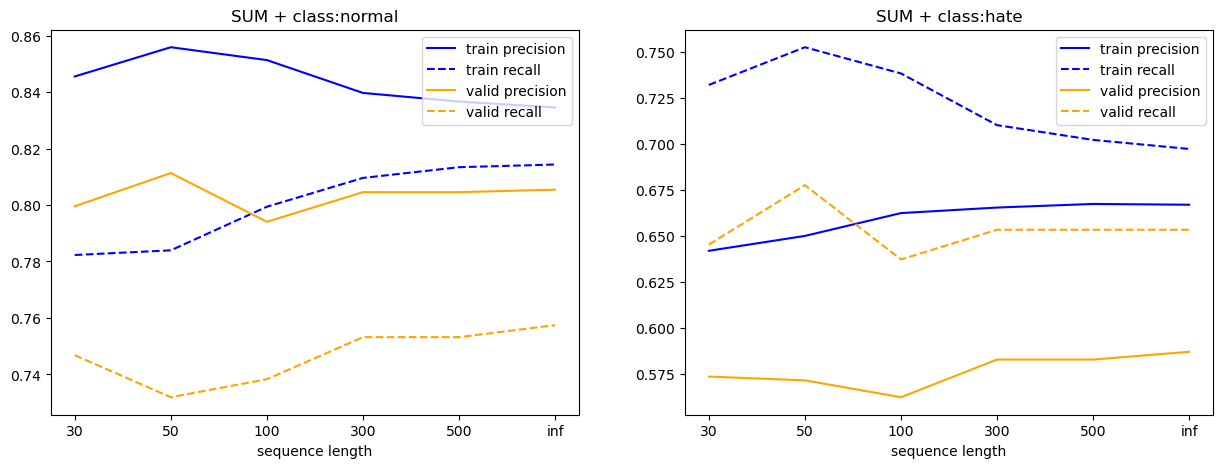

In [220]:
fig, axe = plt.subplots(1, 2, figsize = (15, 5))
indices = np.asarray(seq_lens, dtype=str)
indices[-1] = "inf"

axe[0].plot(indices, normal_train_pr, color="blue", label="train precision")
axe[0].plot(indices, normal_train_rc, color="blue", linestyle="dashed", label="train recall")
axe[0].plot(indices, normal_valid_pr, color="orange", label="valid precision")
axe[0].plot(indices, normal_valid_rc, color="orange", linestyle="dashed", label="valid recall")
axe[0].set_xlabel(r"sequence length")
axe[0].set_title(r"SUM + class:normal") 
axe[0].legend(loc='upper right')

axe[1].plot(indices, hate_train_pr, color="blue", label="train precision")
axe[1].plot(indices, hate_train_rc, color="blue", linestyle="dashed", label="train recall")
axe[1].plot(indices, hate_valid_pr, color="orange", label="valid precision")
axe[1].plot(indices, hate_valid_rc, color="orange", linestyle="dashed", label="valid recall")
axe[1].set_xlabel(r"sequence length")
axe[1].set_title(r"SUM + class:hate")
axe[1].legend(loc='upper right')

plt.show()

In [213]:
import pickle
from sklearn.metrics import *
# sequence + PCA
SEQUENCE_LEN = 30

n_components = [50, 100, 300, 500, 1000, 3000]

def prepare_flatten_dataset(data, seq_len=SEQUENCE_LEN):
    for line in data:
        vectors = []
        for token in jieba.cut(line):
            token = token.strip()
            if token:
#                 vectors.append(pretrained_model.wv[token])
                try: 
                    vectors.append(pretrained_model.wv[token])
                except Exception as err:
                    pass
        diff_len = SEQUENCE_LEN - len(vectors)
        if diff_len > 0:
            vectors.extend([np.zeros(100) for _ in range(diff_len)])
        yield np.asarray(vectors[:seq_len]).flatten()
        
pca_normal_train_pr, pca_normal_train_rc = [], []
pca_hate_train_pr, pca_hate_train_rc = [], []

pca_normal_valid_pr, pca_normal_valid_rc = [], []
pca_hate_valid_pr, pca_hate_valid_rc = [], []

pca_train_accus, pca_valid_accus = [], []

for n in n_components:
    train_seq_X = np.array(list(prepare_flatten_dataset(train_X)))
    valid_seq_X = np.array(list(prepare_flatten_dataset(valid_X)))
    print(train_seq_X.shape, valid_seq_X.shape)

    pca_model = PCA(n_components=n)
    pca_model.fit(train_seq_X)
    train_pca_X = pca_model.transform(train_seq_X)
    valid_pca_X = pca_model.transform(valid_seq_X)
    print(f"PCA variances: {np.sum(pca_model.explained_variance_ratio_)}")
    print(train_pca_X.shape, valid_pca_X.shape)

    # SVM
    # fit the training dataset on the classifier
    seq_SVM = svm.SVC(kernel='rbf', class_weight="balanced")
    # SVM = svm.SVC(C=1.0, kernel='RBF', degree=3, gamma='auto')
    seq_SVM.fit(train_pca_X, train_y)

    pickle.dump(seq_SVM, open("./model/naive_seq_svm.pkl", 'wb'))

    # predict the labels on validation dataset
    pred_train_seq = seq_SVM.predict(train_pca_X)
    pred_valid_seq = seq_SVM.predict(valid_pca_X)

    # Use accuracy_score function to get the accuracy
    target_names = ["normal", "hate"]
    train_accu = accuracy_score(pred_train_seq, train_y)
    print("SVM Accuracy Train -> ", train_accu)
    print(confusion_matrix(train_y, pred_train_seq))
    report = classification_report(train_y, pred_train_seq, target_names=target_names, output_dict=True)
    pca_normal_train_pr.append(report["normal"]["precision"])
    pca_normal_train_rc.append(report["normal"]["recall"])
    pca_hate_train_pr.append(report["hate"]["precision"])
    pca_hate_train_rc.append(report["hate"]["recall"])
    print(report)
    pca_train_accus.append(train_accu)

    valid_accu = accuracy_score(pred_valid_seq, valid_y)
    print("SVM Accuracy Validation -> ", valid_accu)
    print(confusion_matrix(valid_y, pred_valid_seq))
    report = classification_report(valid_y, pred_valid_seq, target_names=target_names, output_dict=True)
    pca_normal_valid_pr.append(report["normal"]["precision"])
    pca_normal_valid_rc.append(report["normal"]["recall"])
    pca_hate_valid_pr.append(report["hate"]["precision"])
    pca_hate_valid_rc.append(report["hate"]["recall"])
    print(report)
    pca_valid_accus.append(valid_accu)

(6457, 3000) (718, 3000)
PCA variances: 0.16676392902253823
(6457, 50) (718, 50)
SVM Accuracy Train ->  0.831190955552114
[[3439  773]
 [ 317 1928]]
{'normal': {'precision': 0.9156017039403621, 'recall': 0.8164767331433999, 'f1-score': 0.86320281124498, 'support': 4212}, 'hate': {'precision': 0.7138097001110699, 'recall': 0.8587973273942093, 'f1-score': 0.779619894864537, 'support': 2245}, 'accuracy': 0.831190955552114, 'macro avg': {'precision': 0.814705702025716, 'recall': 0.8376370302688045, 'f1-score': 0.8214113530547584, 'support': 6457}, 'weighted avg': {'precision': 0.8454417149986305, 'recall': 0.831190955552114, 'f1-score': 0.8341423114348369, 'support': 6457}}
SVM Accuracy Validation ->  0.6462395543175488
[[308 162]
 [ 92 156]]
{'normal': {'precision': 0.77, 'recall': 0.6553191489361702, 'f1-score': 0.7080459770114942, 'support': 470}, 'hate': {'precision': 0.49056603773584906, 'recall': 0.6290322580645161, 'f1-score': 0.5512367491166077, 'support': 248}, 'accuracy': 0.64623

In [221]:
# test dataset evaluation

train_seq_X = np.array(list(prepare_flatten_dataset(train_X)))
test_seq_X = np.array(list(prepare_flatten_dataset(test_X)))
print(train_seq_X.shape, valid_seq_X.shape)

pca_model = PCA(n_components=500)
pca_model.fit(train_seq_X)
train_pca_X = pca_model.transform(train_seq_X)
test_pca_X = pca_model.transform(test_seq_X)
print(f"PCA variances: {np.sum(pca_model.explained_variance_ratio_)}")
print(train_pca_X.shape, test_pca_X.shape)

# SVM
# fit the training dataset on the classifier
seq_SVM = svm.SVC(kernel='rbf', class_weight="balanced")
# SVM = svm.SVC(C=1.0, kernel='RBF', degree=3, gamma='auto')
seq_SVM.fit(train_pca_X, train_y)

pickle.dump(seq_SVM, open("./model/naive_seq_svm.pkl", 'wb'))

# predict the labels on test dataset
pred_train_seq = seq_SVM.predict(train_pca_X)
pred_test_seq = seq_SVM.predict(test_pca_X)

print(confusion_matrix(valid_y, pred_valid_seq))
report = classification_report(test_y, pred_test_seq, target_names=target_names, output_dict=True)
print(report)
print(classification_report(test_y, pred_test_seq, target_names=target_names))

(6457, 3000) (718, 3000)
PCA variances: 0.5545078832046338
(6457, 500) (1794, 500)
[[368 102]
 [119 129]]
{'normal': {'precision': 0.8118279569892473, 'recall': 0.7587939698492462, 'f1-score': 0.7844155844155843, 'support': 1194}, 'hate': {'precision': 0.5752212389380531, 'recall': 0.65, 'f1-score': 0.6103286384976525, 'support': 600}, 'accuracy': 0.7224080267558528, 'macro avg': {'precision': 0.6935245979636502, 'recall': 0.7043969849246231, 'f1-score': 0.6973721114566185, 'support': 1794}, 'weighted avg': {'precision': 0.7326952753667743, 'recall': 0.7224080267558528, 'f1-score': 0.7261925255801556, 'support': 1794}}
              precision    recall  f1-score   support

      normal       0.81      0.76      0.78      1194
        hate       0.58      0.65      0.61       600

    accuracy                           0.72      1794
   macro avg       0.69      0.70      0.70      1794
weighted avg       0.73      0.72      0.73      1794



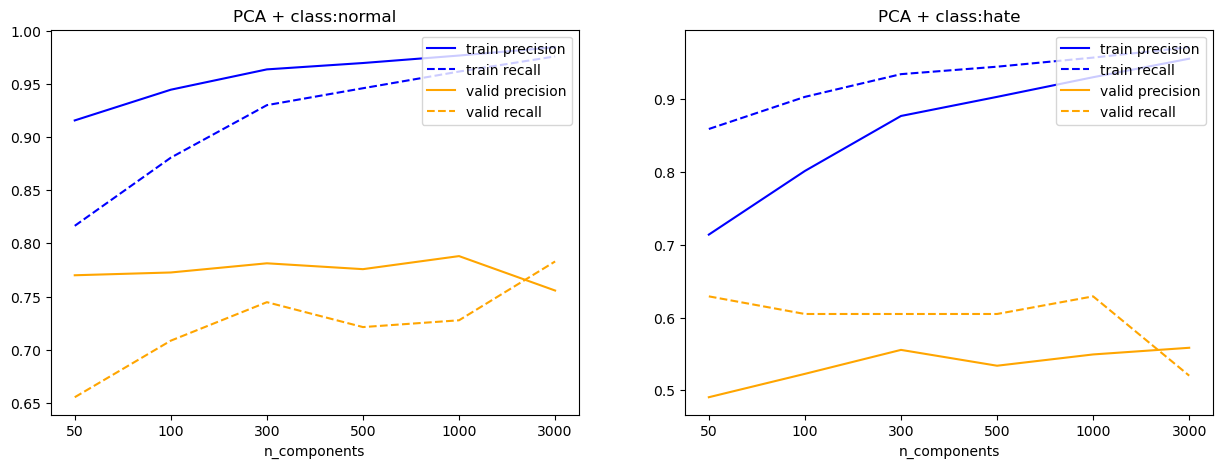

In [215]:
fig, axe = plt.subplots(1, 2, figsize = (15, 5))
indices = np.asarray(n_components, dtype=str)
axe[0].plot(indices, pca_normal_train_pr, color="blue", label="train precision")
axe[0].plot(indices, pca_normal_train_rc, color="blue", linestyle="dashed", label="train recall")
axe[0].plot(indices, pca_normal_valid_pr, color="orange", label="valid precision")
axe[0].plot(indices, pca_normal_valid_rc, color="orange", linestyle="dashed", label="valid recall")
axe[0].set_xlabel(r"n_components")
axe[0].set_title(r"PCA + class:normal")    
axe[0].legend(loc='upper right')

axe[1].plot(indices, pca_hate_train_pr, color="blue", label="train precision")
axe[1].plot(indices, pca_hate_train_rc, color="blue", linestyle="dashed", label="train recall")
axe[1].plot(indices, pca_hate_valid_pr, color="orange", label="valid precision")
axe[1].plot(indices, pca_hate_valid_rc, color="orange", linestyle="dashed", label="valid recall")
axe[1].set_xlabel(r"n_components")
axe[1].set_title(r"PCA + class:hate")   
axe[1].legend(loc='upper right')

plt.show()

[0.16671068981307482, 0.25282055000208253, 0.3188851237334568, 0.3755937869315217, 0.4241580018128618, 0.46314695123866145, 0.502380257776726, 0.5382298797757272, 0.571637931692227, 0.6020434795499953, 0.6302115796098211, 0.656434269036875, 0.680864005318117, 0.7040220828282829, 0.7253130180076989, 0.7452383853920515, 0.7638948259827192, 0.7813837108407966, 0.7981390859473404, 0.8135684786935478, 0.8280064206000612, 0.8415233340839952, 0.8542455010190946, 0.866350800839695, 0.8775094181833536, 0.8879402807578725, 0.8977975182424516, 0.9071621182447493, 0.9157533523644963, 0.9237799882997757, 0.9313100305486571, 0.9382766844398194, 0.9449206773865264, 0.9509740392959022, 0.9565836108182211, 0.9617761047997347, 0.9665930625910872, 0.9710776288544629, 0.9751548831701005, 0.9788705255894906, 0.9828410150950599, 0.9858323017371011, 0.9885699684751743, 0.9909805482564293, 0.9931244063660565, 0.9950072831251913, 0.9966422346697014, 0.9980500298807253, 0.9991800645438751, 1.0]


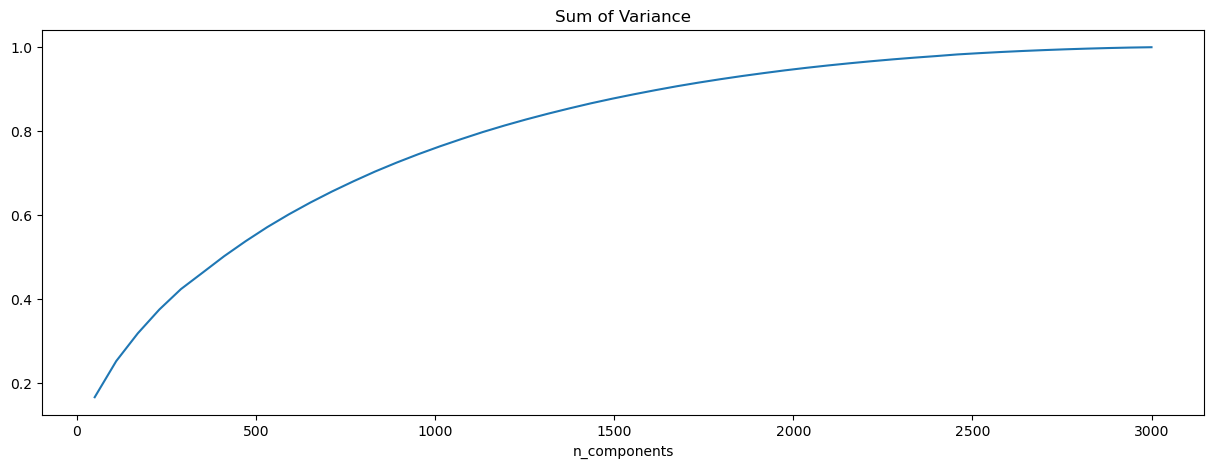

In [168]:
# visualize PCA

from sklearn.decomposition import PCA

n_grids = np.linspace(50, 3000, 50)

# decrease dimension 3000 -> 100
variances = []
for num in n_grids:
    pca_model = PCA(n_components=round(num))
    pca_model.fit(train_seq_X)
    variances.append(np.sum(pca_model.explained_variance_ratio_))
    
print(variances)

# visualization: best components size
fig, axe = plt.subplots(1, 1, figsize = (15, 5))
axe.set_xlabel(r"n_components")
axe.set_title(r"Sum of Variance")
axe.plot(n_grids, variances)

PCA variances: 0.5544151937712889
(6457, 500) (718, 500)
SVM Accuracy Train ->  92.50425894378195
[[4177   35]
 [ 449 1796]]
              precision    recall  f1-score   support

      normal       0.90      0.99      0.95      4212
        hate       0.98      0.80      0.88      2245

    accuracy                           0.93      6457
   macro avg       0.94      0.90      0.91      6457
weighted avg       0.93      0.93      0.92      6457

SVM Accuracy Validation ->  71.86629526462396
[[416  54]
 [148 100]]
              precision    recall  f1-score   support

      normal       0.74      0.89      0.80       470
        hate       0.65      0.40      0.50       248

    accuracy                           0.72       718
   macro avg       0.69      0.64      0.65       718
weighted avg       0.71      0.72      0.70       718



In [175]:
# ROC
# pred: 1d array
# groundtruth: 1d array
# classifier_name: string, 随便写
def ROC_curve_binary(pred, ground_truth, classifier_name):
    fpr, tpr, _ = sklearn.metrics.roc_curve(ground_truth, pred)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="orange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve of " + classifier_name)
    plt.legend(loc="lower right")
    plt.show()
    
# PCA on dataset 
# train_data: 2d array-like, n*100, sentence embedding vectors on training set
# train_label: 1d array-like, 100.
# test_data: 2d array-like, n*100, sentence embedding vectors on testing set
# test_label: 1d array-like, 100.
def visualize_data_2D(train_data, train_label, test_data, test_label, embedding_name):
    fig, ax = plt.subplots(2, 1, figsize = (5, 10))
    
    pca_2d = PCA(n_components=2)
    pca_2d.fit(train_data)
    print("Variance ratio after 2D decomposition on training set:")
    print(pca_2d.explained_variance_ratio_)
    pca_2d.fit(test_data)
    print("Variance ratio after 2D decomposition on testing set:")
    print(pca_2d.explained_variance_ratio_)
    
    train_2d = pca_2d.transform(train_data)
    test_2d = pca_2d.transform(test_data)
    
    train_2d_pos = []
    train_2d_neg = []
    test_2d_pos = []
    test_2d_neg = []
    
    for i in range(len(train_2d)):
        if train_label[i] == 1:
            train_2d_pos.append(train_2d[i])
        else:
            train_2d_neg.append(train_2d[i])
            
    for i in range(len(test_2d)):
        if test_label[i] == 1:
            test_2d_pos.append(test_2d[i])
        else:
            test_2d_neg.append(test_2d[i])
        
    train_2d_pos = np.array(train_2d_pos)
    train_2d_neg = np.array(train_2d_neg)
    test_2d_pos = np.array(test_2d_pos)
    test_2d_neg = np.array(test_2d_neg)
    
    ax[0].scatter(train_2d_pos[:, 0], train_2d_pos[:, 1], c='orange', marker='o', label='normal')
    ax[0].scatter(train_2d_neg[:, 0], train_2d_neg[:, 1], c='navy', marker='^', label='hate')
    ax[0].set_title("Positive and negative 2D samples on training set, " + embedding_name)
    
    ax[1].scatter(test_2d_pos[:, 0], test_2d_pos[:, 1], c='orange', marker='o', label='normal')
    ax[1].scatter(test_2d_neg[:, 0], test_2d_neg[:, 1], c='navy', marker='^', label='hate')
    ax[1].set_title("Positive and negative 2D samples on testing set, " + embedding_name)
     
    ax[0].legend()
    ax[1].legend()

# same as above
def visualize_data_3D(train_data, train_label, test_data, test_label, embedding_name):
    fig = plt.figure(figsize=(10, 20))
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    ax2 = fig.add_subplot(2, 1, 2, projection='3d')
    
    pca_3d = PCA(n_components=3)
    pca_3d.fit(train_data)
    print("Variance ratio after 3D decomposition on training set:")
    print(pca_3d.explained_variance_ratio_)
    pca_3d.fit(test_data)
    print("Variance ratio after 3D decomposition on testing set:")
    print(pca_3d.explained_variance_ratio_)

    train_3d = pca_3d.transform(train_data)
    test_3d = pca_3d.transform(test_data)

    train_3d_pos = []
    train_3d_neg = []
    test_3d_pos = []
    test_3d_neg = []
    for i in range(len(train_3d)):
        if train_label[i] == 1:
            train_3d_pos.append(train_3d[i])
        else:
            train_3d_neg.append(train_3d[i])
            
    for i in range(len(test_3d)):
        if test_label[i] == 1:
            test_3d_pos.append(test_3d[i])
        else:
            test_3d_neg.append(test_3d[i])
    
    train_3d_pos = np.array(train_3d_pos)
    train_3d_neg = np.array(train_3d_neg)
    test_3d_pos = np.array(test_3d_pos)
    test_3d_neg = np.array(test_3d_neg)

    ax.scatter(train_3d_pos[:, 0], train_3d_pos[:, 1], train_3d_pos[:, 2], c='orange', marker='o', label='normal')
    ax.scatter(train_3d_neg[:, 0], train_3d_neg[:, 1], train_3d_neg[:, 2], c='navy', marker='^', label='hate')
    ax.view_init(elev=10)
    ax.set_title("Positive and negative 3D samples on training set, " + embedding_name)
        
    ax2.scatter(test_3d_pos[:, 0], test_3d_pos[:, 1], test_3d_pos[:, 2], c='orange', marker='o', label='normal')
    ax2.scatter(test_3d_neg[:, 0], test_3d_neg[:, 1], test_3d_neg[:, 2], c='navy', marker='^', label='hate')
    ax2.view_init(elev=10)
    ax2.set_title("Positive and negative 3D samples on testing set, " + embedding_name)
    
    
    ax.legend()
    ax2.legend()

(6457, 500) (718, 500)
Variance ratio after 2D decomposition on training set:
[0.05233383 0.01240116]
Variance ratio after 2D decomposition on testing set:
[0.06895302 0.01866082]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

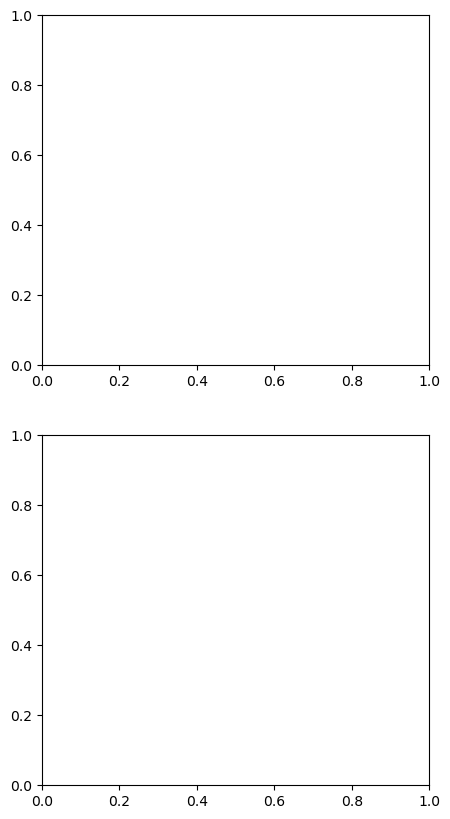

In [179]:
print(train_pca_X.shape, valid_pca_X.shape)

visualize_data_2D(train_pca_X, train_y, valid_pca_X, valid_y, "sentence embedding-PCA:500")